# Prédiction du nombre de nouveaux étudiants en L1

## 1. Prétraitement des données

- Importation des librairies
- Importation du jeu de données
- Nettoyage des données:
    1. Verification s'il y a des données manquantes au jeu de données

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Récupéraion du dataset

In [241]:
df = pd.read_csv("datas/prop_admi_post_bac.csv",sep=";")

Visualisation des données

In [242]:
df.head(5)

,Année du Baccalauréat,Enseignements de spécialité,Formation,Nombre de candidats bacheliers ayant confirmé au moins un vœu,Nombre de candidats bacheliers ayant reçu au moins une proposition d'admission,Nombre de candidats bacheliers ayant accepté une proposition d'admission
0,2021,"Art,Art","Licence Electronique, Génie électrique, EEA",0,0.0,0
1,2021,"Art,Art",Licence Formation générale aux métiers de l in...,0,0.0,0
2,2021,"Art,Art",Licence LEA,0,0.0,0
3,2021,"Art,Art",Licence Mathématiques,0,0.0,0
4,2021,"Art,Art",Licence Mathématiques et informatique,0,0.0,0


Nous vérifions si une colonne comporte des données manquantes. Comme nous pouvons le voir, aucune ligne n'est vide.

In [243]:
df.isna().sum()

Année du Baccalauréat                                                             0
Enseignements de spécialité                                                       0
Formation                                                                         0
Nombre de candidats bacheliers ayant confirmé au moins un vœu                     0
Nombre de candidats bacheliers ayant reçu au moins une proposition d'admission    0
Nombre de candidats bacheliers ayant accepté une proposition d'admission          0
dtype: int64

Renommage des colonnes par soucis de simplification lors du traitement.

In [244]:
df.rename(columns={"Année du Baccalauréat" : "annee",
           "Enseignements de spécialité" : "spe",
           "Formation": "formation",
           "Nombre de candidats bacheliers ayant confirmé au moins un vœu" : "voeu_confirme",
           "Nombre de candidats bacheliers ayant reçu au moins une proposition d'admission" : "prop_recu",
           "Nombre de candidats bacheliers ayant accepté une proposition d'admission" : "prop_accepte"}, inplace=True)
df.head(5)

,annee,spe,formation,voeu_confirme,prop_recu,prop_accepte
0,2021,"Art,Art","Licence Electronique, Génie électrique, EEA",0,0.0,0
1,2021,"Art,Art",Licence Formation générale aux métiers de l in...,0,0.0,0
2,2021,"Art,Art",Licence LEA,0,0.0,0
3,2021,"Art,Art",Licence Mathématiques,0,0.0,0
4,2021,"Art,Art",Licence Mathématiques et informatique,0,0.0,0


Vérification et correction au besoin des types de données.

Ici on remarque que prop_recu est de type float64. Aucune des valeurs de la colonne n'est de type float, on peu donc passer la colonne en Int.

In [245]:
df.dtypes

annee              int64
spe               object
formation         object
voeu_confirme      int64
prop_recu        float64
prop_accepte       int64
dtype: object

In [246]:
df["prop_recu"].value_counts().unique()

array([4022, 1091,  641,  412,  325,  257,  228,  216,  169,  141,  132,
        117,  115,   91,   87,   82,   78,   75,   74,   71,   65,   60,
         59,   52,   48,   46,   43,   42,   40,   39,   37,   36,   35,
         34,   29,   27,   25,   23,   22,   21,   20,   19,   18,   17,
         16,   15,   14,   13,   12,   11,   10,    9,    8,    7,    6,
          5,    4,    3,    2,    1])

In [247]:
df["prop_recu"] = df["prop_recu"].astype(int)

In [248]:
df.dtypes

annee             int64
spe              object
formation        object
voeu_confirme     int64
prop_recu         int64
prop_accepte      int64
dtype: object

On sait que le nouveau bac demande à choisir une spécialité dominante et une spécialité secondaire. On remarque que la colonne spe sépare ses données par une virgule, mais parfois le nom d'une spécialité contient une virgule. On remarque également que lorsque la virgule sépare deux spécialités (Art,Art), il n'y a pas d'espace après celle-ci, et que quand la virgule est dans le nom d'une spécialité, (Histoire-Géographie, Géopolitique et Sciences politiques), il y a un espace après la virgule. 

Pour pouvoir continuer à traiter les données nous décidons de séparer la colonne `spe` en deux colonnes distinctes, l'une contenant la spécialité principale `spe_prim` et l'autre la spécialité secondaire `spe_sec`.
Le but est ainsi de pouvoir aisement trier selon l'une ou l'autre des spécialités ainsi que de pouvoir comparer les duos de spécialité menant à une certaine formation dans l'enseignement supérieur.

In [249]:
import re

def split_string(text):
    result = re.split(r'(?<=\w),(?=\w)', text)
    return pd.Series([result[0],result[1]])

df[['spe_prim', 'spe_sec']] = df['spe'].apply(split_string)

## Lecture des données

Nous avons 6 variables différentes dans notre dataset :

- annee :
    - L'année du passage du BAC pour les étudiants
    - type *int*, [2021-2023]
- spé :
    - Spécialités lors du passage du BAC
    - type *(string, string)*: (spé1,spé2)
- formation : 
    - Formation postulés par les étudiants, 
    - type *string*
- voeu_accepté :
    - Nombre de voeux confirmés par les étudiants
    - type *int*, [0, inf]
- prop_recu :
    - Nombre de propositions d'admission reçus par les étudiants
    - type *int*, [0, prop_reçu]
- prop_accepte :
     - Nombre de proposition d'admission acceptés par les étudiants
    - type *int*, [0, voeu_accepté]

## Première visualisation

Pour commencer, nous allons regarder globalement ce que nous disent ces données. Pour se faire nous allons faire deux visualisations. 

- La première consiste à regarder pour chaque duo de spécialités :
    - Quelle formation ce duo demande le plus.
    - De quelle formation ce duo reçois le plus de propositions d'admissions.
    - Dans quelle formation ce duo accepte finnalement une proposition d'admission.
- La seconde sera la même chose mais du point de vue de chaque formation:
    - Quel duo de spécialité demande le plus cette formation.
    - A quel duo cette formation envoie le plus d'offre d'admissions.
    - De quel duo de spécialité cette formation reçois finalement le plus d'étudiants.

Cette première visualisation nous permettra de mettre en évidence une première tendance entre les formations et les duos.

Dans les données pour chaque années et chaque duo de formation se trouve une ligne "Ensemble des bacheleirs" qui regroupe pour cette année et ce duo le total des demandes et confirmations. Pour que la visualisation ne nous donne pas à chaque fois ce total, on utilise un mask pour enlever la ligne en question, mais sans l'enlever de notre dataframe car on pourrait en avoir besoin plus tard.

In [250]:
mask_no_ens_bac = (df["formation"] != "Ensemble des bacheliers")
max_clean = df[mask_no_ens_bac]["voeu_confirme"].max()
print(max_clean)

59892


In [251]:
def create_graph(df,colonne, annee) :
    df_graph = df.head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_graph, x=colonne, y='spe', hue='formation')
    plt.title(f'Nombre de {colonne} par spécialisation et formation pour l\'année {annee}.')
    plt.xlabel(f'Nombre de {colonne}')
    plt.ylabel('Spécialité')
    plt.legend()
    plt.show()

In [252]:
def get_graph_by_year_column(annee, colonne):
    df_tmp = pd.DataFrame()
    for i in df["spe"].unique():
        mask = ((df["annee"] == annee) & (df["spe"] == i) & (df["formation"] != "Ensemble des bacheliers"))
        max = df[mask][colonne].max()
        new_mask = ((df["annee"] == annee) & (df["spe"] == i) & (df["formation"] != "Ensemble des bacheliers") & (df[colonne] == max))

        df_tmp = pd.concat([df_tmp,df[new_mask]],ignore_index=True)
        df_tmp = df_tmp.sort_values(by=colonne,ascending=False)
    create_graph(df_tmp,colonne, annee)
    

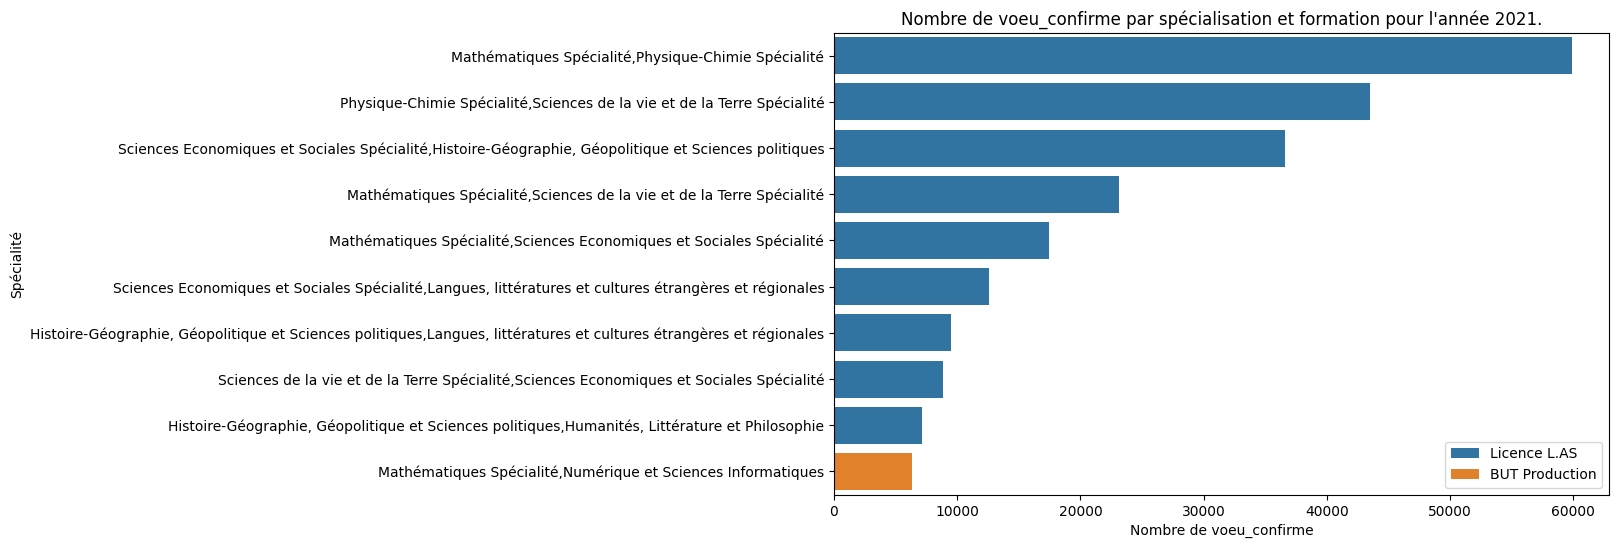

In [253]:
get_graph_by_year_column(2021, "voeu_confirme")

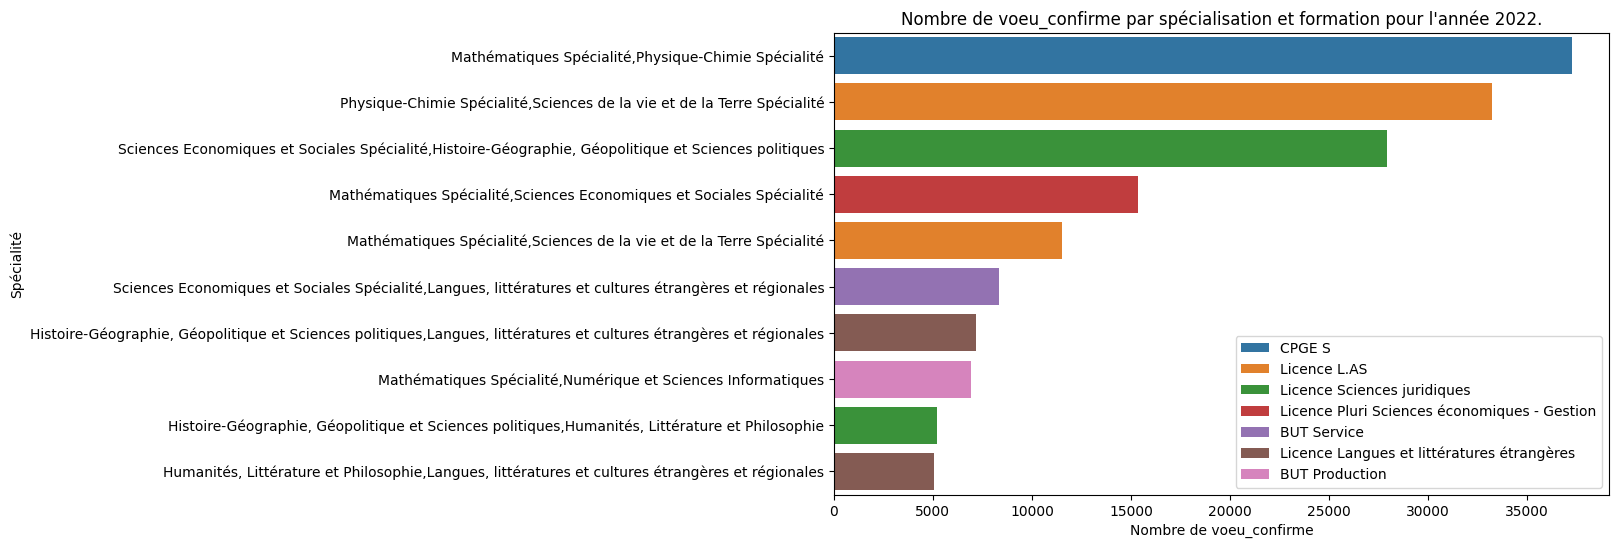

In [254]:
get_graph_by_year_column(2022, "voeu_confirme")

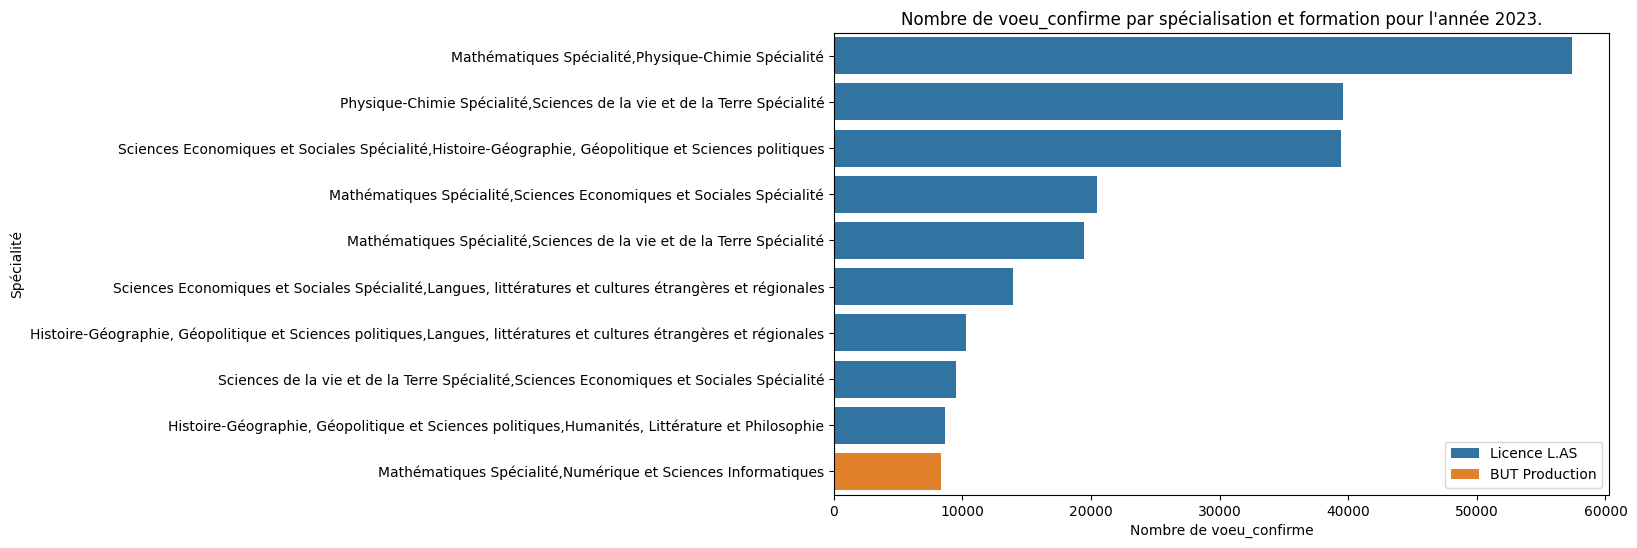

In [255]:
get_graph_by_year_column(2023, "voeu_confirme")

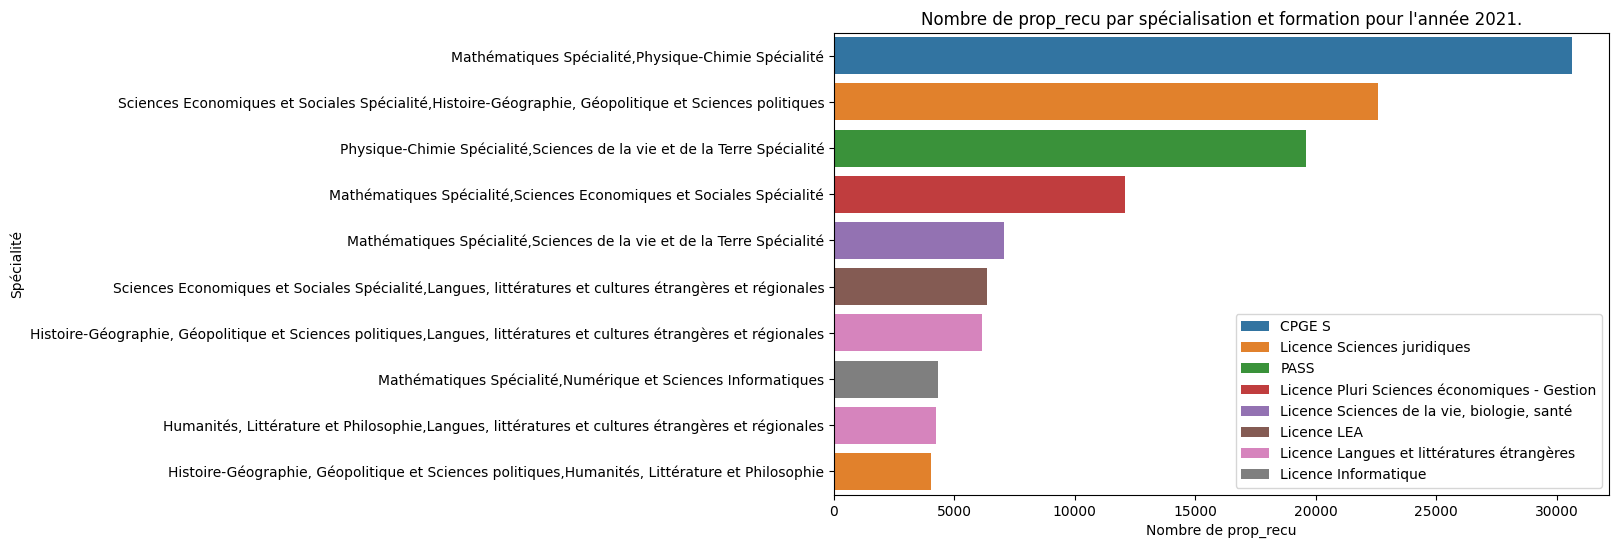

In [256]:
get_graph_by_year_column(2021, "prop_recu")

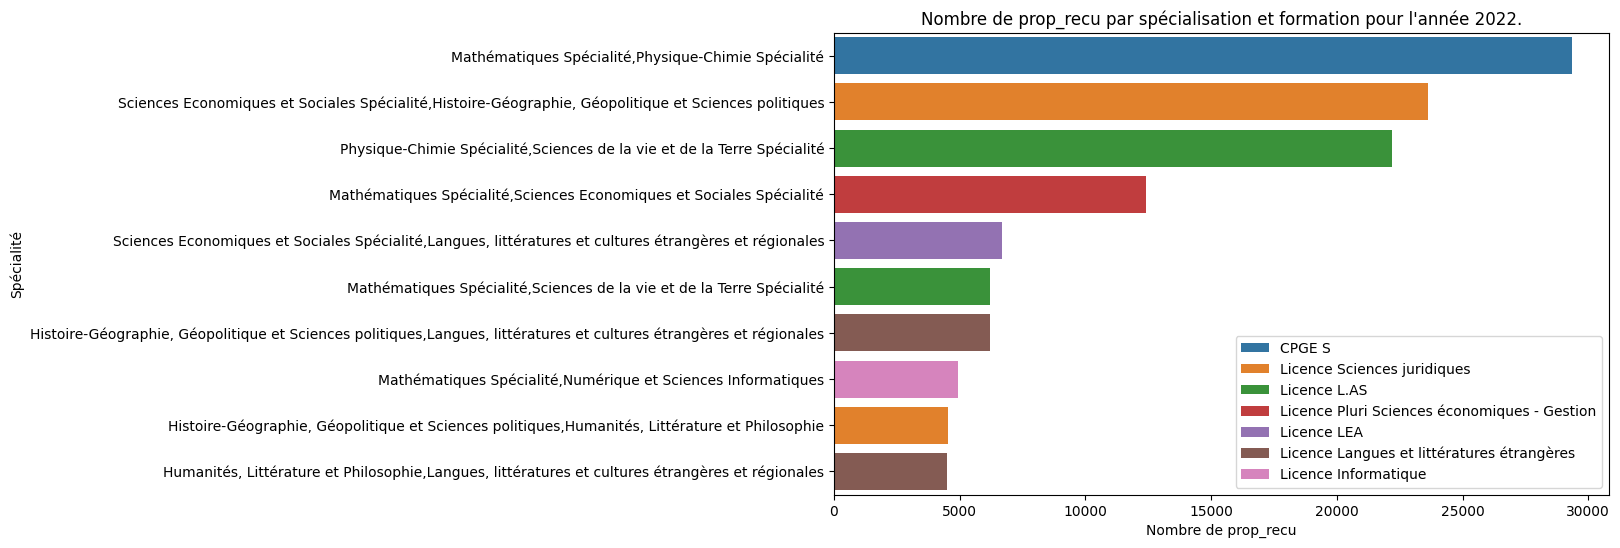

In [257]:
get_graph_by_year_column(2022, "prop_recu")

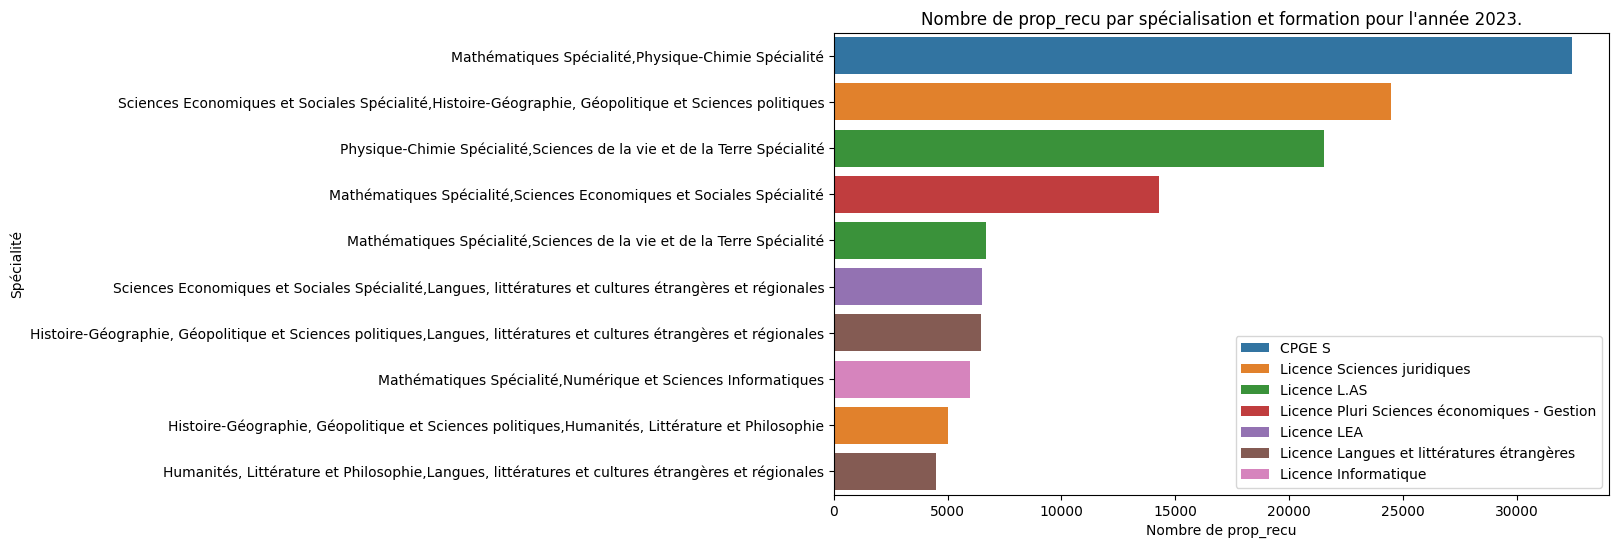

In [258]:
get_graph_by_year_column(2023, "prop_recu")

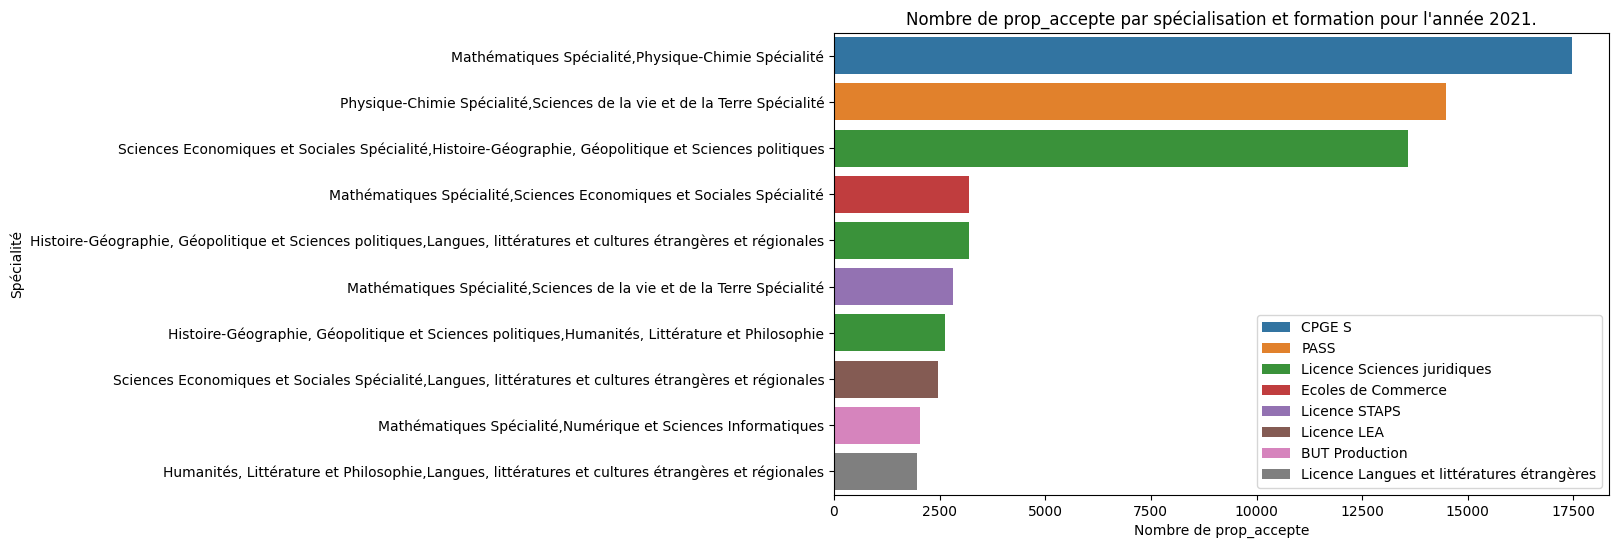

In [259]:
get_graph_by_year_column(2021, "prop_accepte")

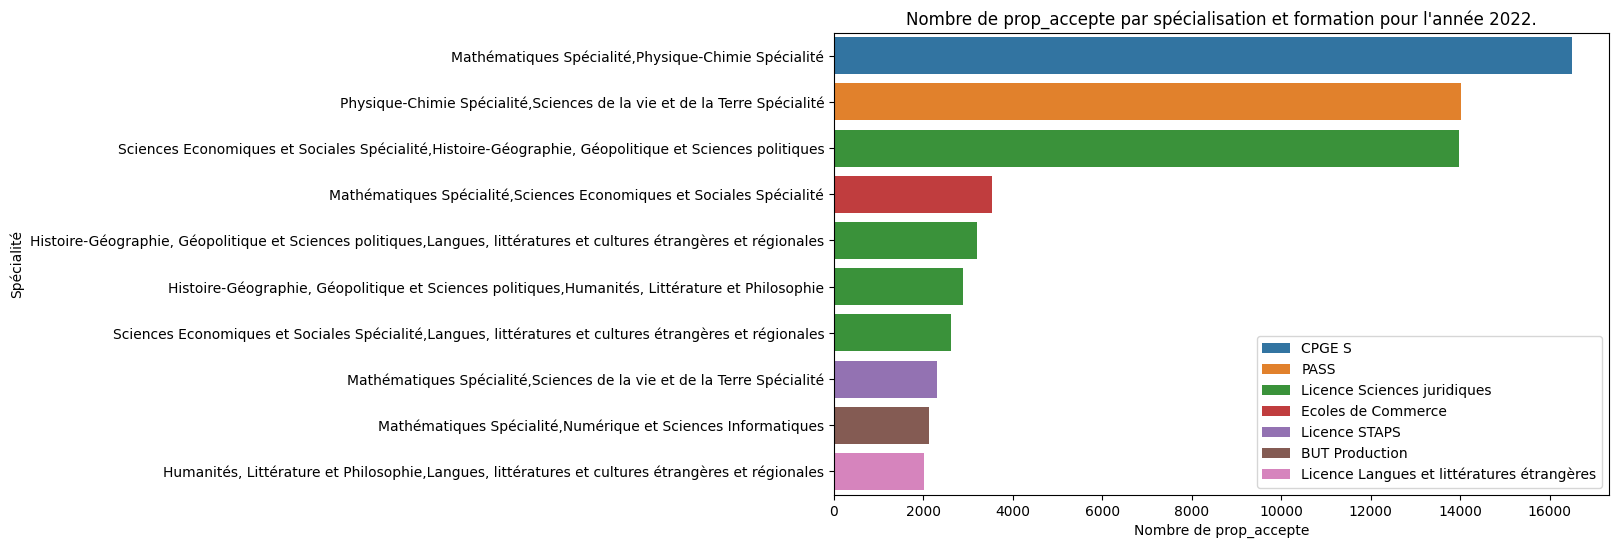

In [260]:
get_graph_by_year_column(2022, "prop_accepte")

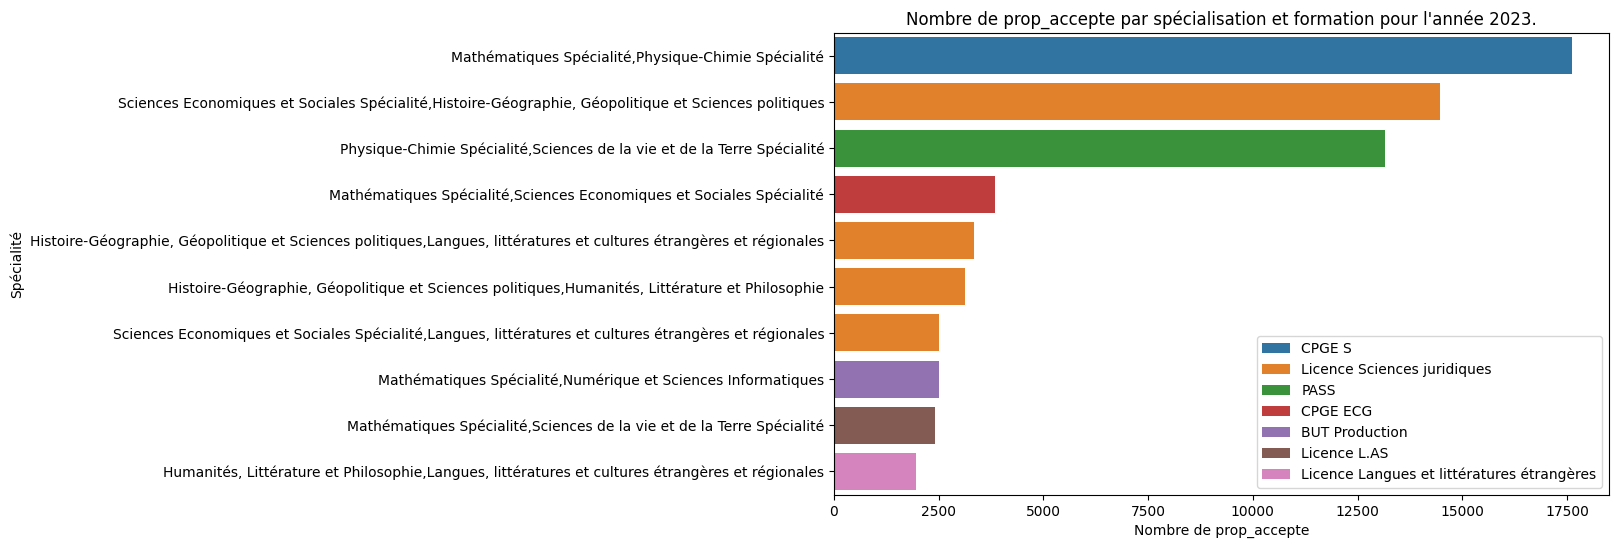

In [261]:
get_graph_by_year_column(2023, "prop_accepte")